Use Nasdaq as the universe and alpha 101 as the factors

In [52]:
from pathlib import Path
from datetime import datetime
from zoneinfo import ZoneInfo

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

In [2]:
data_dir = Path("../../../data")
stock_dir = data_dir / "nasdaq100"
qqq_path = data_dir / "QQQ.csv"

## Read Nasdaq 100 stocks and QQQ as benchmark

In [3]:
def parse_date(datetime_str: str) -> datetime:
    dt, tz = datetime_str.rsplit(" ", maxsplit=1)

    date_time_obj = datetime.strptime(dt, "%Y%m%d %H:%M:%S").replace(
        tzinfo=ZoneInfo(tz)
    )
    return date_time_obj


def read_stock(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(
        file_path, names=["date", "open", "high", "low", "close", "volume"]
    )
    df["date"] = df["date"].map(parse_date)
    df.set_index("date", inplace=True)
    return df


def plot_stock(df: pd.DataFrame, ticker: str) -> None:
    """Plot stock price with plotly and show earning rate in title."""
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=df.index, y=df["close"], mode="lines", name="close")
    )

    er = (df["close"].iloc[-1] - df["close"].iloc[0]) / df["close"].iloc[0]
    fig.update_layout(title=f"{ticker} | Earning Rate: {er:.2%}")
    fig.show()


def sharpe_ratio(df: pd.DataFrame, risk_free: float = None) -> float:
    """Calculate sharpes ratio."""
    pc = df["close"].pct_change()
    if risk_free:
        return (pc.mean() - risk_free) / pc.std()
    else:
        return pc.mean() / pc.std()

In [4]:
df_qqq = read_stock(qqq_path)

In [5]:
stocks = {}

for stock in tqdm(stock_dir.glob("*.csv")):
    ticker = stock.stem
    df = read_stock(stock)
    stocks[ticker] = df

    # print(f"{ticker} Sharpe Ratio: {sharpe_ratio(df, risk_free=0.04):.2f}")
    # print(f"{ticker} CAGR: {((df['close'].iloc[-1] / df['close'].iloc[0]) ** (1/len(df)) - 1):.2%}")
    # print(f"{ticker} Max Drawdown: {((df['close'].max() - df['close'].min()) / df['close'].max()):.2%}")
    # print(f"{ticker} Beta: {df['close'].corr(df_qqq['close']):.2f}")
    # print(f"{ticker} Alpha: {((df['close'].pct_change() - 0.01).mean() - (df_qqq['close'].pct_change() - 0.01).mean()):.2%}")

101it [00:09, 10.42it/s]


In [48]:
df = pd.concat(stocks.values(), keys=stocks.keys(), axis=1)

In [49]:
(len(df) - len(df.dropna(how="any"))) / len(df)

0.8083896742470805

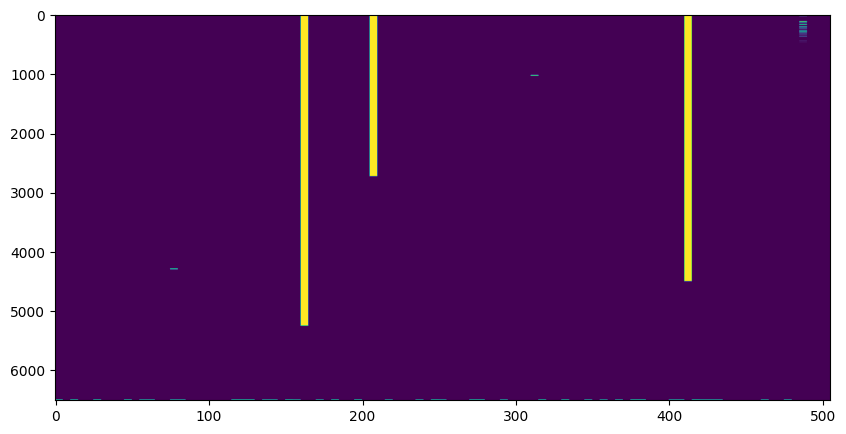

In [50]:
# visualize nan values
plt.figure(figsize=(10, 5))
plt.imshow(df.isnull(), aspect="auto")

In [51]:
for ticker in df.columns.levels[0]:
    # count nan ratio
    nan_ratio = df[ticker].isnull().sum() / len(df)
    if nan_ratio.max() > 0.2:
        # get first non-nan date
        first_date = df[ticker][df[ticker].notna().all(axis=1)].index[0]
        print(f"{ticker} has nan ratio: {nan_ratio.max():.2%}, first date: {first_date}")

DASH has nan ratio: 80.72%, first date: 2023-09-27 09:30:00-04:00
GEHC has nan ratio: 41.86%, first date: 2022-12-15 09:30:00-05:00
ROP has nan ratio: 69.13%, first date: 2023-07-06 09:30:00-04:00


In [56]:
datetime.fromtimestamp(ticker.info["firstTradeDateEpochUtc"])

datetime.datetime(2020, 12, 9, 23, 30)

In [57]:
for ticker in ["DASH", "GEHC", "ROP"]:
    ticker = yf.Ticker(ticker)
    # get IPO date
    print(datetime.fromtimestamp(ticker.info["firstTradeDateEpochUtc"]).strftime("%Y-%m-%d"))

2020-12-09
2022-12-15
1992-02-13


The data missing is caused by API, but still, let's drop them

In [58]:
df = df.drop(columns=["DASH", "GEHC", "ROP"])